In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.externals.six import StringIO 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
import sklearn
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import decomposition
from sklearn.model_selection import cross_val_score

# XGBoost
import xgboost as xgb

# Pandas
import pandas as pd

# Numpy
import numpy as np
# Set random seed
np.random.seed(0)

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
raw = pd.read_csv('KeplerData.csv')
print(raw.shape)
raw.head()

(9564, 102)


,loc_rowid,KepID,Exoplanet Archive Disposition,Disposition Using Kepler Data,Disposition Score,Not Transit-Like False Positive Flag,Stellar Eclipse False Positive Flag,Centroid Offset False Positive Flag,Ephermeris Match Indicates Contamination False Positive Flag,Orbital Period [days],...,PRF Delta Delta SQ (OOT) [arcsec],PRF Delta Delta SQ (OOT) Unc.,PRF Delta Theta SQ (OOT) [arcsec],PRF Delta Theta SQ (OOT) Unc.,PRF Delta Alpha SQ (KIC) [arcsec],PRF Delta Alpha SQ (KIC) Unc.,PRF Delta Delta SQ (KIC) [arcsec],PRF Delta Delta SQ (KIC) Unc.,PRF Delta Theta SQ (KIC) [arcsec],PRF Delta Theta SQ (KIC) Unc.
0,1,10797460,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [3]:
target_name = 'Exoplanet Archive Disposition'
feature_names = list(raw.columns[4:])
data = raw[[target_name, *feature_names]]
# remove canidates for prediction (2244 rows)
data = raw[raw[target_name] != 'CANDIDATE']
# IMPUTE
# Fill Disposition Score with 0.5
data['Disposition Score'] = data['Disposition Score'].fillna(.5)
# Fill flags with 0
flag_names = ['Not Transit-Like False Positive Flag', 'Stellar Eclipse False Positive Flag', 'Centroid Offset False Positive Flag', 'Ephermeris Match Indicates Contamination False Positive Flag']
data[flag_names] = data[flag_names].fillna(0)
# Fill all other nulls with median
data = data.fillna(data.median())
print(data.shape)
data.head()

/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


(7320, 102)


,loc_rowid,KepID,Exoplanet Archive Disposition,Disposition Using Kepler Data,Disposition Score,Not Transit-Like False Positive Flag,Stellar Eclipse False Positive Flag,Centroid Offset False Positive Flag,Ephermeris Match Indicates Contamination False Positive Flag,Orbital Period [days],...,PRF Delta Delta SQ (OOT) [arcsec],PRF Delta Delta SQ (OOT) Unc.,PRF Delta Theta SQ (OOT) [arcsec],PRF Delta Theta SQ (OOT) Unc.,PRF Delta Alpha SQ (KIC) [arcsec],PRF Delta Alpha SQ (KIC) Unc.,PRF Delta Delta SQ (KIC) [arcsec],PRF Delta Delta SQ (KIC) Unc.,PRF Delta Theta SQ (KIC) [arcsec],PRF Delta Theta SQ (KIC) Unc.
0,1,10797460,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [4]:
train, test = sklearn.model_selection.train_test_split(data)
y_train = train[target_name]
X_train = train[feature_names]
y_test = test[target_name]
X_test = test[feature_names]
# X_train, X_test, y_train, y_test = \
#     train_test_split(features, target, test_size=.4, random_state=42)

In [5]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

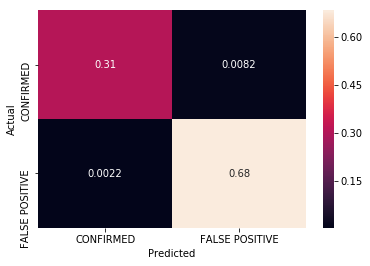

In [6]:
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize=True)
sns.heatmap(confusion, annot=True)

In [7]:
cv_scores_rf = cross_val_score(clf, X_test, y_test, cv=5)

print("Accuracy:\t\t", np.mean(cv_scores_rf))
print("Completeness:\t\t", sklearn.metrics.recall_score(y_test, y_pred, average='micro'))
print("Contamination:\t\t", 1 - sklearn.metrics.precision_score(y_test, y_pred, average='micro'))

Accuracy:		 0.9896174863387976
Completeness:		 0.9896174863387979
Contamination:		 0.01038251366120213


In [9]:
values = list(zip(data[feature_names], clf.feature_importances_))
#plt.barh(range(len(clf.feature_importances_)), [x[1] for x in values])
sortd = sorted(values, reverse = True, key= lambda x: x[1])[:20]
important_names = [s[0] for s in sortd]
sortd

[('Disposition Score', 0.22369020173412796),
 ('Stellar Metallicity Lower Uncertainty [dex]', 0.10348054108590621),
 ('FW Offset Significance [percent]', 0.05018733934590841),
 ('Planetary Radius [Earth radii].1', 0.04756017895519683),
 ('Not Transit-Like False Positive Flag', 0.04419041715833792),
 ('PRF Delta Theta SQ (OOT) [arcsec]', 0.037883370819387106),
 ('Transit Duration Lower Uncertainty [hrs]', 0.037214900633599605),
 ('PRF Delta Theta SQ (KIC) [arcsec]', 0.03374556922952393),
 ('Stellar Effective Temperature Lower Uncertainty [K]', 0.032792667077629366),
 ('Planetary Radius Lower Unc. [Earth radii]', 0.027714994759798783),
 ('Centroid Offset False Positive Flag', 0.024329605208136193),
 ('Stellar Mass Upper Uncertainty [Solar mass]', 0.021442675931962814),
 ('Number of Planets', 0.019782520409816238),
 ('Planet-Star Distance over Star Radius', 0.01796391913151592),
 ('Planetary Radius Upper Unc. [Earth radii]', 0.017638097349242272),
 ('Planetary Radius [Earth radii]', 0.014

In [10]:
# A quick look at the count of null values in the original data
important_withnulls = raw[[*important_names, target_name]]
important_withnulls.describe()

,Disposition Score,Stellar Metallicity Lower Uncertainty [dex],FW Offset Significance [percent],Planetary Radius [Earth radii].1,Not Transit-Like False Positive Flag,PRF Delta Theta SQ (OOT) [arcsec],Transit Duration Lower Uncertainty [hrs],PRF Delta Theta SQ (KIC) [arcsec],Stellar Effective Temperature Lower Uncertainty [K],Planetary Radius Lower Unc. [Earth radii],Centroid Offset False Positive Flag,Stellar Mass Upper Uncertainty [Solar mass],Number of Planets,Planet-Star Distance over Star Radius,Planetary Radius Upper Unc. [Earth radii],Planetary Radius [Earth radii],Transit Depth Lower Uncertainty [ppm],Insolation Flux [Earth flux],Transit Signal-to-Noise,FW delta-Alpha Unc.
count,8054.000000,9177.000000,8488.000000,9201.000000,9564.000000,8965.000000,9110.000000,8994.000000,9081.000000,9201.000000,9564.000000,9096.000000,9564.000000,9201.000000,9201.000000,9201.000000,9110.000000,9.243000e+03,9201.000000,9109.000000
mean,0.480829,-0.252033,0.150994,102.891778,0.188206,1.866561,-0.339942,1.812566,-162.265059,-33.023314,0.194898,0.122801,1.406315,76.736333,17.657684,0.283646,-123.197563,7.745737e+03,259.895001,0.703913
std,0.476928,0.085453,0.252648,3077.639126,0.390897,2.988742,0.669823,2.986376,72.746348,1193.519910,0.396143,0.085946,0.873289,845.274598,391.138501,3.306558,4112.615230,1.592047e+05,795.806615,0.663513
min,0.000000,-0.750000,0.000000,0.080000,0.000000,0.000000,-20.200000,0.000000,-1762.000000,-77180.000000,0.000000,0.000000,1.000000,0.373000,0.000000,0.001289,-388600.000000,0.000000e+00,0.000000,0.000140
25%,0.000000,-0.300000,0.000000,1.400000,0.000000,0.170000,-0.350000,0.210000,-198.000000,-1.940000,0.000000,0.072000,1.000000,5.358000,0.230000,0.012341,-49.500000,2.015000e+01,12.000000,0.170000
50%,0.334000,-0.300000,0.006000,2.390000,0.000000,0.610000,-0.142000,0.583000,-160.000000,-0.300000,0.000000,0.106000,1.000000,15.460000,0.520000,0.021076,-20.750000,1.416000e+02,23.000000,0.570000
75%,0.998000,-0.150000,0.196250,14.930000,0.000000,2.160000,-0.050800,1.970000,-114.000000,-0.140000,0.000000,0.151000,1.000000,45.370000,2.320000,0.095348,-9.600000,8.702900e+02,78.000000,1.100000
max,1.000000,0.000000,1.000000,200346.000000,1.000000,88.600000,0.000000,89.600000,0.000000,0.000000,1.000000,1.500000,7.000000,79614.000000,21640.000000,99.870651,0.000000,1.094755e+07,9054.700000,11.000000


In [11]:
important_withnulls.isnull().sum()

Disposition Score                                      1510
Stellar Metallicity Lower Uncertainty [dex]             387
FW Offset Significance [percent]                       1076
Planetary Radius [Earth radii].1                        363
Not Transit-Like False Positive Flag                      0
PRF Delta Theta SQ (OOT) [arcsec]                       599
Transit Duration Lower Uncertainty [hrs]                454
PRF Delta Theta SQ (KIC) [arcsec]                       570
Stellar Effective Temperature Lower Uncertainty [K]     483
Planetary Radius Lower Unc. [Earth radii]               363
Centroid Offset False Positive Flag                       0
Stellar Mass Upper Uncertainty [Solar mass]             468
Number of Planets                                         0
Planet-Star Distance over Star Radius                   363
Planetary Radius Upper Unc. [Earth radii]               363
Planetary Radius [Earth radii]                          363
Transit Depth Lower Uncertainty [ppm]   

Disposition Score                           \
                                          count      mean       std  min   
Exoplanet Archive Disposition                                              
CONFIRMED                                2297.0  0.960214  0.147813  0.0   
FALSE POSITIVE                           5023.0  0.116014  0.204737  0.0   

                                                         
                                 25%  50%    75%    max  
Exoplanet Archive Disposition                            
CONFIRMED                      0.992  1.0  1.000  1.000  
FALSE POSITIVE                 0.000  0.0  0.103  0.957

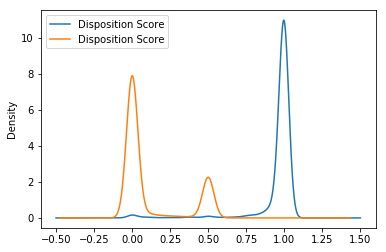

In [13]:
# here we look at the most important feature
fig, axs = plt.subplots(ncols=1)
koi_score = data[['Disposition Score', target_name]]
koi_score.groupby(data[target_name]).plot(kind='kde', ax=axs)
koi_score.groupby(data[target_name]).describe()

In [14]:
# sns.pairplot(data[[*important_names[:3], target_name]], hue=target_name)

In [ ]:
# Rerun using only the top most important features
important = data[[*important_names, target_name]]
train, test = sklearn.model_selection.train_test_split(important)
y_train = train[target_name]
X_train = train[important_names]
y_test = test[target_name]
X_test = test[important_names]
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize=True)
sns.heatmap(confusion, annot=True)
cv_scores_rf = cross_val_score(clf, X_test, y_test, cv=5)

print("Accuracy:\t\t", np.mean(cv_scores_rf))
print("Completeness:\t\t", sklearn.metrics.recall_score(y_test, y_pred, average='micro'))
print("Contamination:\t\t", 1 - sklearn.metrics.precision_score(y_test, y_pred, average='micro'))

In [97]:
# iris = np.array(important)
# species = target
# iris_colors = {'FALSE POSITIVE': 'g', 'CONFIRMED': 'r'}

# pca = decomposition.PCA(n_components=2)
# pca.fit(iris)
# iris_pca = pca.transform(iris)

# # projected coordinates
# fig, ax = plt.subplots(figsize = (10, 5))
# for specie in np.unique(species):
#     mask = (species == specie)
#     ax.scatter(iris_pca[mask][:, 0], iris_pca[mask][:, 1], label = specie, c = iris_colors[specie], alpha = 0.1)

# # loading vectors
# eviris = 2. * pca.components_
# for idx, var in enumerate(most_important[:-1]):
#     ax.plot([0, eviris[0, idx]], [0, eviris[1, idx]])
#     #ax.text(eviris[0, idx], eviris[1, idx], var)
# ax.set_xlabel("PCA 1")
# ax.set_ylabel("PCA 2")
# ax.legend();

In [99]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# preprocess dataset, split into training and test part
X, y = data[important_names], data[target_name]
#X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

In [100]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cv_scores_rf = cross_val_score(clf, X_test, y_test, cv=5)
    print(name)
    print("Accuracy:\t\t", np.mean(cv_scores_rf))
    print("Completeness:\t\t", sklearn.metrics.recall_score(y_test, y_pred, average='micro'))
    print("Contamination:\t\t", 1 - sklearn.metrics.precision_score(y_test, y_pred, average='micro'))
    print('\n')

Nearest Neighbors
Accuracy:		 0.8284110275689223
Completeness:		 0.8389194597298649
Contamination:		 0.16108054027013508


Linear SVM
Accuracy:		 0.5697844611528822
Completeness:		 0.5697848924462231
Contamination:		 0.4302151075537769


RBF SVM
Accuracy:		 0.9884912280701755
Completeness:		 0.9909954977488744
Contamination:		 0.00900450225112559


Gaussian Process
Accuracy:		 0.9789849624060152
Completeness:		 0.9829914957478739
Contamination:		 0.017008504252126078


Decision Tree
Accuracy:		 0.9409749373433585
Completeness:		 0.9549774887443722
Contamination:		 0.04502251125562784


Random Forest
Accuracy:		 0.9904924812030075
Completeness:		 0.9949974987493747
Contamination:		 0.005002501250625291


Neural Net
Accuracy:		 0.9689761904761905
Completeness:		 0.9829914957478739
Contamination:		 0.017008504252126078


AdaBoost
Accuracy:		 0.9859862155388471
Completeness:		 0.983991995997999
Contamination:		 0.016008004002000975




/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [102]:
# Getting wwarning Variables are collinear
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif["features"] = X.columns